In [1]:
import os
import uuid
import random
import psycopg2
import numpy as np
import scipy.interpolate
import scipy.io as sio
import matplotlib.cm as cm
import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from psycopg2 import Error
from scipy.fft import fft, rfftfreq

In [2]:
__connection = psycopg2.connect(user="postgres",
                                     password='2325070307',
                                     host="127.0.0.1",
                                     port="5432",
                                     database='tpu')
cursor = __connection.cursor()

In [3]:
model_name='111'
alpha = '4'

In [4]:
if not os.path.isdir(f'{os.getcwd()}\\report {model_name}_{alpha}'):
   os.mkdir(f'{os.getcwd()}\\report {model_name}_{alpha}')

In [3]:
alpha = 4
model_name = '111'
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_4
                where model_name = (%s)
            """, (model_name,))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_6
                where model_name = (%s)
            """, (model_name,))
__connection.commit()
x, z = cursor.fetchall()[0]

if alpha == '4' or alpha == 4:
    cursor.execute("""
                select face_number
                from experiments_alpha_4
                where model_name = (%s)
            """, (model_name,))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select face_number
                from experiments_alpha_6
                where model_name = (%s)
            """, (model_name,))
__connection.commit()
face_number = cursor.fetchall()[0][0]

angle = 0
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_4
                where model_id = (
                select model_id
                from experiments_alpha_4
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_6
                where model_id = (
                select model_id
                from experiments_alpha_6
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))
__connection.commit()
pressure_coefficients = cursor.fetchall()[0][0]
pr_norm = np.array(pressure_coefficients)/1000

In [290]:
len(pr_norm)

32768

In [4]:
np.max(1,2,3,4)

TypeError: output must be an array

In [295]:
rms_pr = np.sqrt(pr_norm.T.dot(pr_norm.T)/pr_norm.T.size)

ValueError: shapes (500,32768) and (500,32768) not aligned: 32768 (dim 1) != 500 (dim 0)

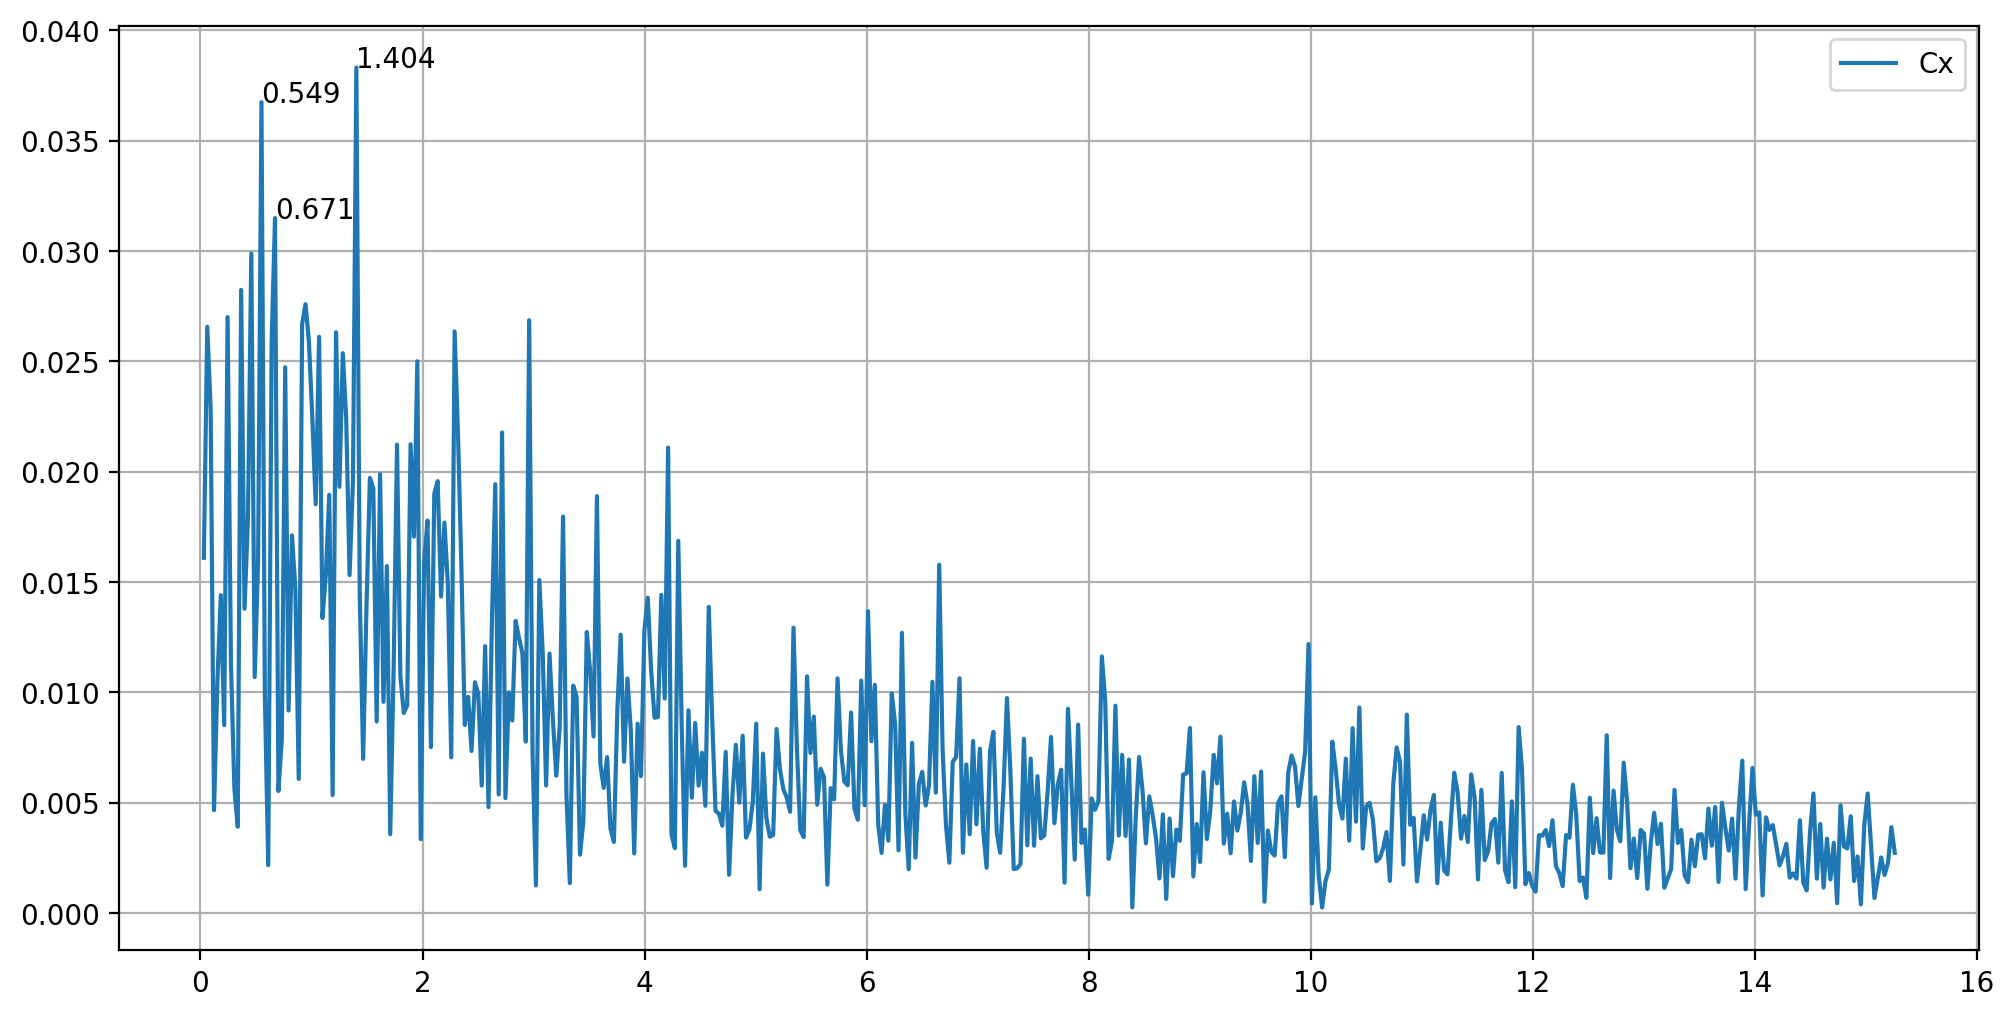

<Figure size 640x480 with 0 Axes>

In [24]:
count_sensors_on_model = len(pr_norm[0])
count_sensors_on_middle = int(model_name[0]) * 5
count_sensors_on_side = int(model_name[1]) * 5
count_row = count_sensors_on_model // (2 * (count_sensors_on_middle + count_sensors_on_side))

sum_int_x = []
sum_int_y = []

for coeff in pr_norm:
    coeff = np.reshape(coeff, (count_row, -1))
    coeff = np.split(coeff, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
    del coeff[4]
    faces_x = []
    faces_y = []
    for face in range(len(coeff)):
        if face in [0, 2]:
            faces_x.append(np.sum(coeff[face]) / (count_sensors_on_model / 4))
        else:
            faces_y.append(np.sum(coeff[face]) / (count_sensors_on_model / 4))

    sum_int_x.append((faces_x[0] - faces_x[1]))
    sum_int_y.append((faces_y[0] - faces_y[1]))
N = len(sum_int_x)

yfCx = (1 / N) * (np.abs(fft(sum_int_x)))[1:N // 2]
yfCy = (1 / N) * (np.abs(fft(sum_int_y)))[1:N // 2]

FD = 1000
xf = rfftfreq(N, 1 / FD)[1:N // 2]

border = 500
count_peaks = 3

fig, ax = plt.subplots(figsize=(12, 6), dpi=200, num=1, clear=True)

for data, name in zip([yfCx, yfCy], ['Cx', 'Cy']):
    ax.plot(xf[:border], data[:border], antialiased=True, label=name)
    peaks = np.sort(data[:border])[::-1][:count_peaks]

    for peak in range(count_peaks):
        x = xf[:border][np.where(data[:border] == peaks[peak])].round(3)[0]
        y = peaks[peak]
        ax.annotate(x, xy=(x,y))

    ax.legend()
    ax.grid()
    plt.savefig(f'Отчет {model_name}_{alpha}\\Спектр {name} {model_name}_{alpha}.png')
    plt.show()
    ax.clear()


In [294]:
pr_norm.T[0]

array([0.932, 0.803, 0.823, ..., 0.979, 1.02 , 0.9  ])

In [127]:
breadth, depth, height = int(model_name[0]) / 10, int(model_name[1]) / 10, int(model_name[2]) / 10
size_x = 2*(breadth + depth)
sensors_on_model=len(pr_norm[0])

In [ ]:
x_new, y_new = converter_coordinates(x,depth, breadth, face_number, sensors_on_model)

In [299]:
info_sensors = []
mean_pr = np.mean(pr_norm, axis=0)
rms_pr = [np.sqrt(i.dot(i)/i.size) for i in pr_norm.T]
std_pr = np.std(pr_norm, axis=0)
max_pr = np.max(pr_norm, axis=0)
min_pr = np.min(pr_norm, axis=0)

for i in range(sensors_on_model):
    row = [i+1,x_new[i], y_new[i],z[i],mean_pr[i],rms_pr[i],std_pr[i],max_pr[i],min_pr[i],None,None]
    info_sensors.append(row)

In [304]:
len(min_pr)

500

In [270]:
np.sqrt(pr_norm[0].dot(pr_norm[0])/pr_norm[0].size)

0.7757033556714834

In [296]:
np.sqrt(np.mean(np.square(pr_norm.T)))

0.7646137620899242

In [285]:
len(pr_norm[0])

500

In [283]:
np.std(pr_norm[0])

0.6522498888493581

In [272]:
import time

In [282]:
t1=time.time()
for i in range(10000):
    np.sqrt(np.mean(np.square(pr_norm[0])))
print(time.time()-t1)

0.11300778388977051


In [4]:
def converter_coordinates(x_old, depth, breadth, face_number, count_sensors):
    """Возвращает из (x_old) -> (x,y)"""
    x = []
    y = []
    for i in range(count_sensors):
        if face_number[i] == 1:
            x.append(float('%.5f' % (-depth / 2)))
            y.append(float('%.5f' % (breadth / 2 - x_old[i])))
        elif face_number[i] == 2:
            x.append(float('%.5f' % (- depth / 2 + x_old[i] - breadth)))
            y.append(float('%.5f' % (-breadth / 2)))
        elif face_number[i] == 3:
            x.append(float('%.5f' % (depth / 2)))
            y.append(float('%.5f' % (-3 * breadth / 2 + x_old[i] - depth)))
        else:
            x.append(float('%.5f' % (3 * depth / 2 - x_old[i] + 2 * breadth)))
            y.append(float('%.5f' % (breadth / 2)))

    return x, y

In [5]:
[i for i in range(0,45,5)]

[0, 5, 10, 15, 20, 25, 30, 35, 40]

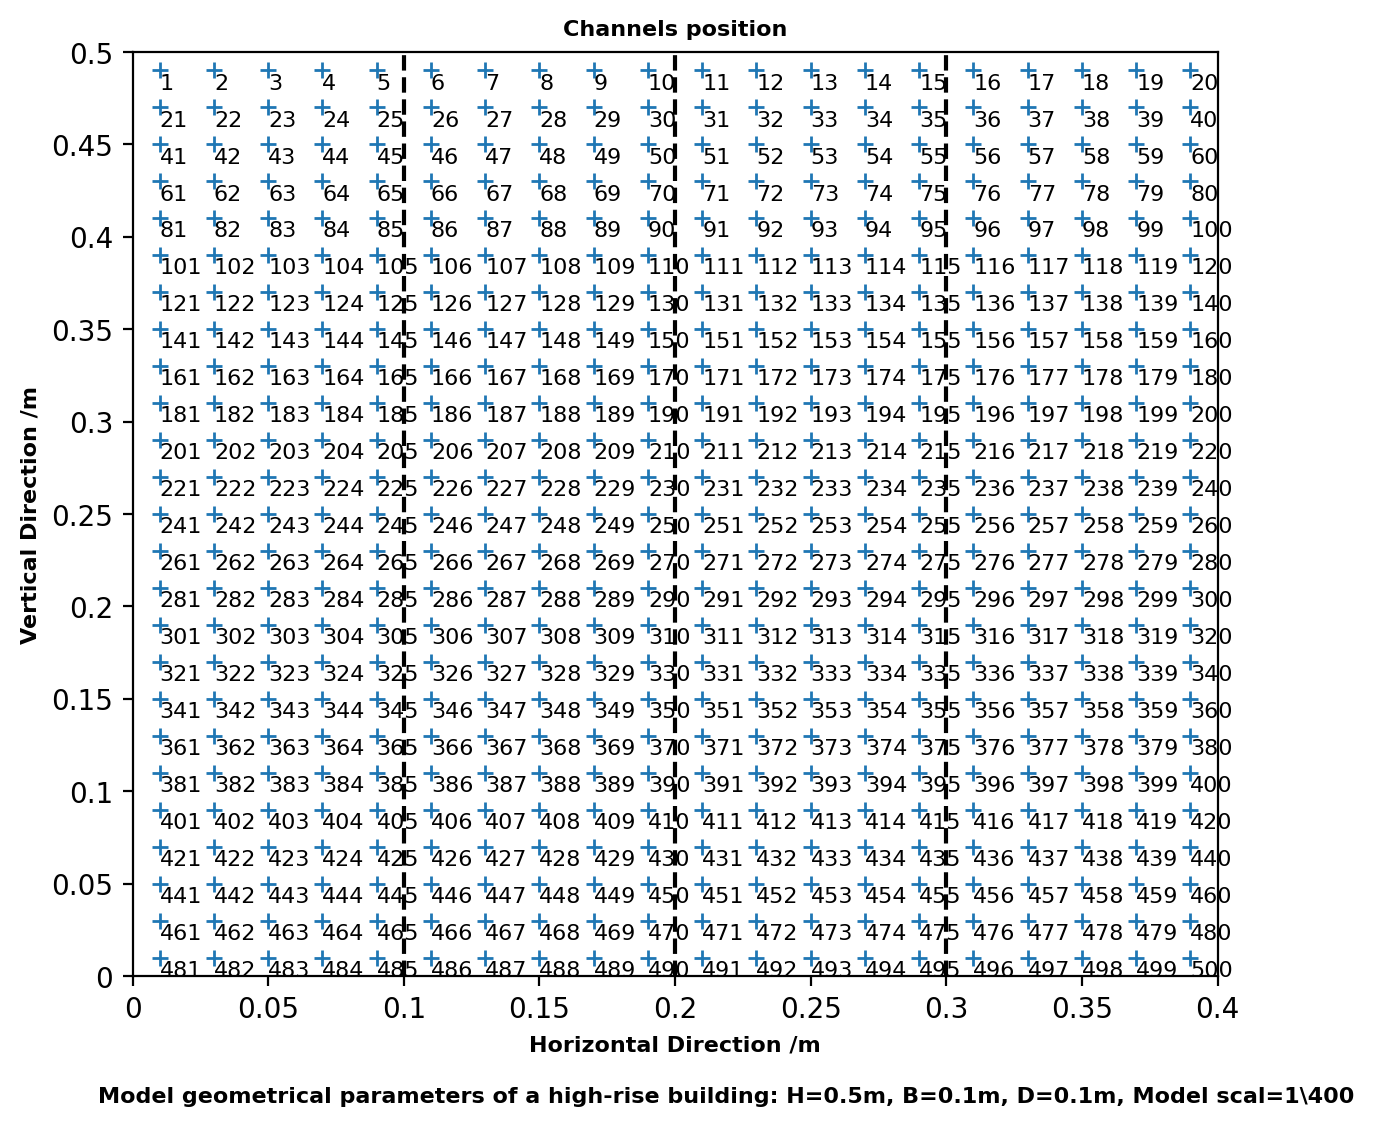

In [243]:
fig, ax = plt.subplots(figsize=(7,6), dpi=200, num=1, clear=True)
ax.set_title('Channels position',fontweight='semibold',fontsize=8)
ax.set_xlabel('Horizontal Direction /m',fontweight='semibold',fontsize=8)
ax.set_ylabel('Vertical Direction /m',fontweight='semibold',fontsize=8)
fig.text(0.1, 0.005, f'Model geometrical parameters of a high-rise building: H={height}m, B={breadth}m, D={depth}m, '
                         f'Model scal=1\\{alpha}00',fontweight='semibold', fontsize=8)
ax.set_ylim(0,height)
ax.set_xlim(0,size_x)
xtick_v = 0.05
ytick_v = 0.02 if height in [0.1, 0.2] else 0.05
xticks = np.arange(0,size_x+xtick_v,xtick_v)
yticks = np.arange(0,height+ytick_v,ytick_v)
xlabels = ['0'] + [str(i)[:4].rstrip('0') for i in xticks[1:]]
ylabels = ['0'] + [str(i)[:4].rstrip('0') for i in yticks[1:]]
ax.set_xticks(xticks,labels=xlabels)
ax.set_yticks(yticks,labels=ylabels)
for i in range(1,int(size_x*10)):
    ax.plot([i/10,i/10],[0,height],linestyle='--', color='black')
ax.plot(x,z,'+')
for i,j,text in zip(x,z,[str(i) for i in range(1,sensors_on_model+1)]):
    ax.text(i,j-0.01,text,fontsize=8)
ax.set_aspect('equal') if height == 0.1 else None
plt.savefig(f'Model {model_name}_{alpha}.png')

In [5]:
breadth, depth, height = int(model_name[0]) / 10, int(model_name[1]) / 10, int(model_name[2]) / 10
count_sensors_on_model = len(pr_norm[0])
count_sensors_on_middle = int(model_name[0]) * 5
count_sensors_on_side = int(model_name[1]) * 5
count_row = count_sensors_on_model // (2 * (count_sensors_on_middle + count_sensors_on_side))
s13_row = height*breadth/count_row
s24_row = height*depth/count_row
s13_face = height*breadth
s24_face = height*depth

NameError: name 'pr_norm' is not defined

In [23]:
sum_int_x = []
sum_int_y = []
for coeff in pr_norm:

    coeff = np.reshape(coeff, (count_row, -1))
    coeff = np.split(coeff, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
    del coeff[4]
    faces_x = []
    faces_y = []
    for face in range(len(coeff)):
        if face in [0,2]:
            faces_x.append(np.sum(coeff[face])/(count_sensors_on_model/4))
        else:
            faces_y.append(np.sum(coeff[face])/(count_sensors_on_model/4))
    
    sum_int_x.append((faces_x[0]-faces_x[1]))
    sum_int_y.append((faces_y[0]-faces_y[1]))

In [353]:
len(pr_norm.T[0])

32768

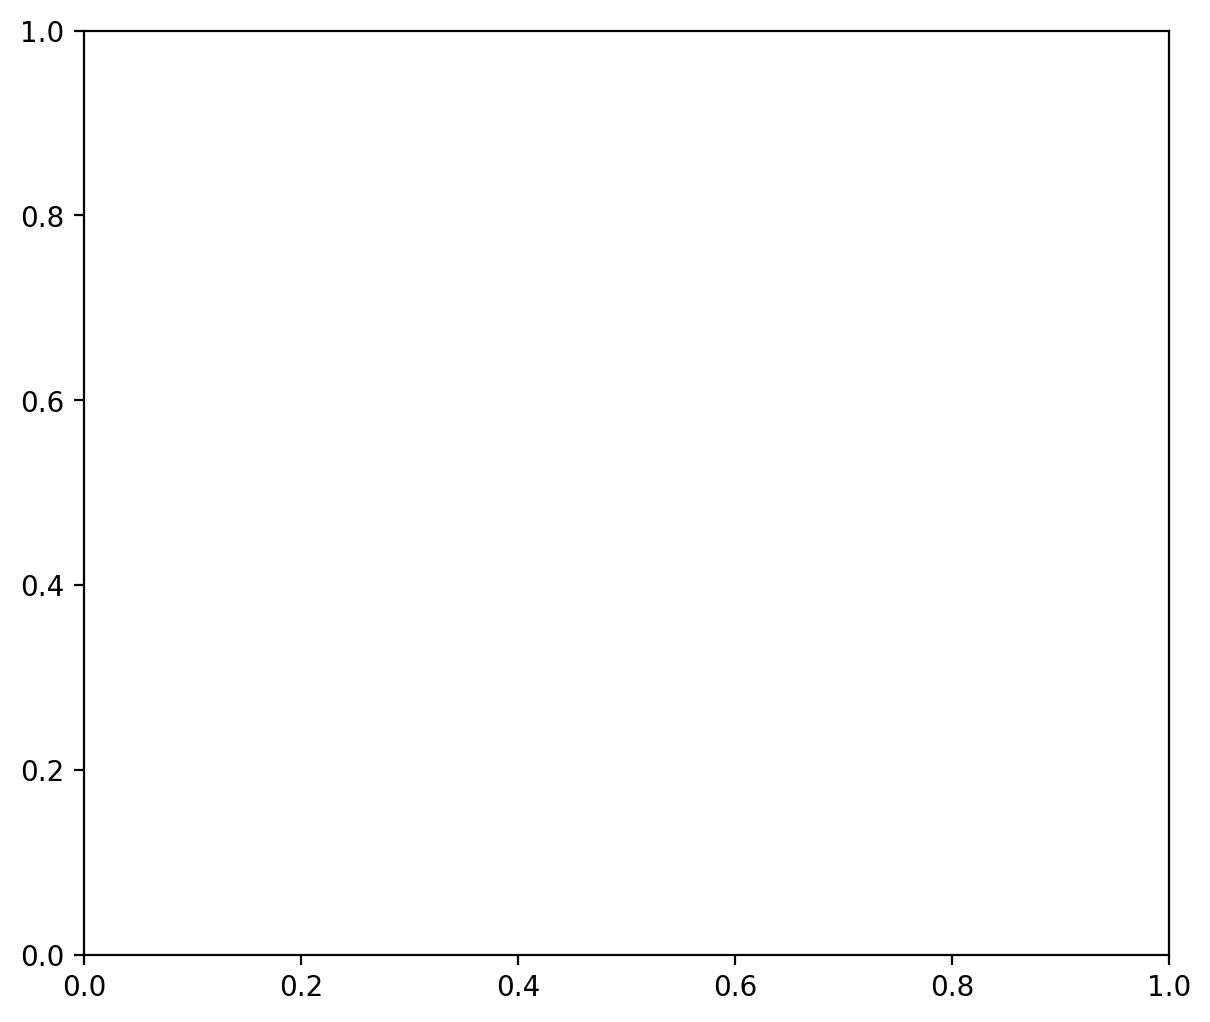

In [24]:
fig, ax = plt.subplots(figsize=(7,6), dpi=200,num=1, clear=True)
for data, name in zip([sum_int_x,sum_int_y],["CX","CY"]):
    ax.plot(list(range(1,32769)),data,label=name)
    ax.legend()
    ax.grid()
    plt.savefig(f'{name} {model_name}_{alpha}.png')
    ax.clear()

In [25]:
np.arange(0,count_sensors_on_model+20,20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500])

In [22]:
[f'{i:02}' for i in range(0,50,5)]

['00', '05', '10', '15', '20', '25', '30', '35', '40', '45']

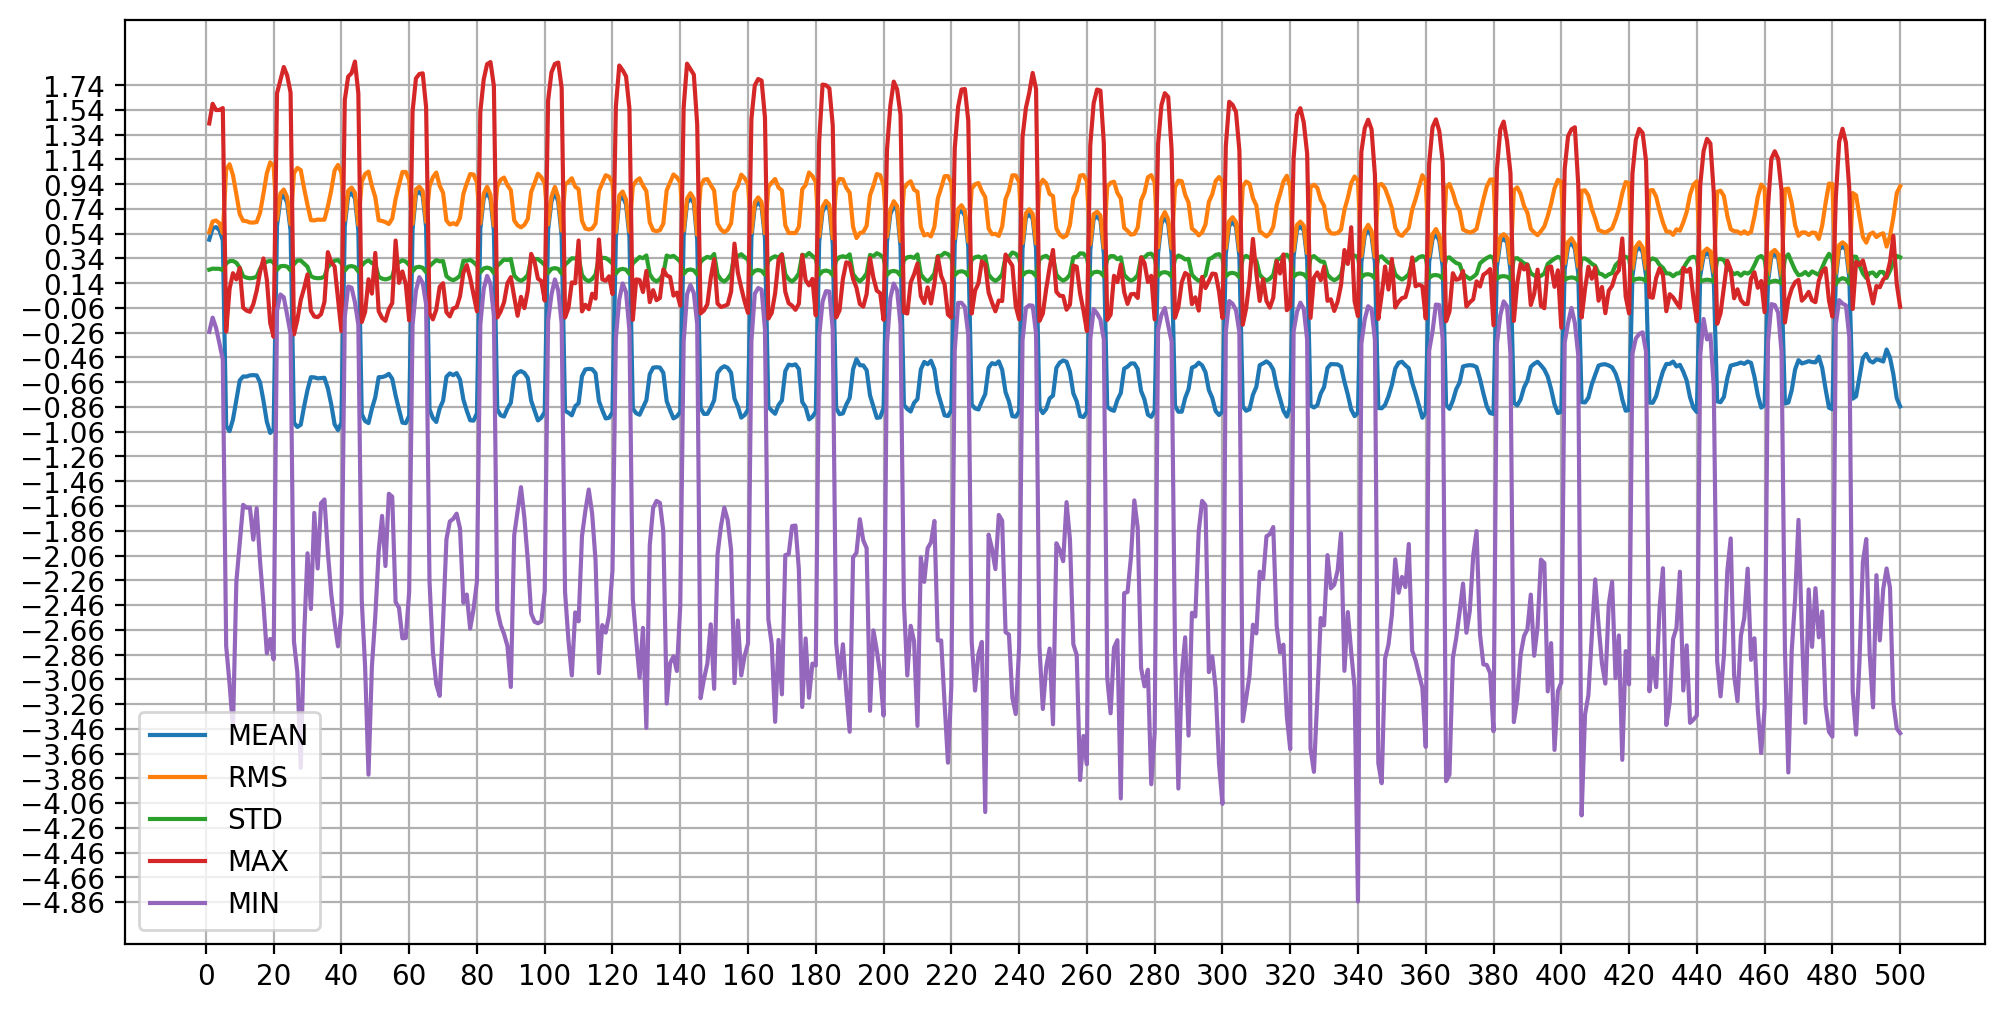

In [19]:
fig, ax = plt.subplots(figsize=(12,6), dpi=200,num=1, clear=True)
ax.plot([i for i in range(1,count_sensors_on_model + 1)], mean_pr,'-',label='MEAN')
ax.plot([i for i in range(1,count_sensors_on_model + 1)], rms_pr,'-',label='RMS')
ax.plot([i for i in range(1,count_sensors_on_model + 1)], std_pr,'-',label='STD')
ax.plot([i for i in range(1,count_sensors_on_model + 1)], max_pr,'-',label='MAX')
ax.plot([i for i in range(1,count_sensors_on_model + 1)], min_pr,'-',label='MIN')
xticks = np.arange(0,count_sensors_on_model+20,20)
yticks = np.arange(np.min(min_pr),np.max(max_pr),0.2).round(2)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.legend()
ax.grid()


In [244]:
from docx import Document
from docx.shared import Inches,Pt,Mm
from docx.enum.text import WD_ALIGN_PARAGRAPH

In [20]:
len(pr_norm)

32768

In [13]:
info_sensors = []
mean_pr = np.mean(pr_norm, axis=0).round(4)
rms_pr = np.array([np.sqrt(i.dot(i)/i.size) for i in pr_norm.T]).round(4)
std_pr = np.std(pr_norm, axis=0).round(4)
max_pr = np.max(pr_norm, axis=0).round(4)
min_pr = np.min(pr_norm, axis=0).round(4)
sensors_on_model = count_sensors_on_model

for i in range(sensors_on_model):
    row = [i+1,x_new[i], y_new[i],z[i],mean_pr[i],rms_pr[i],std_pr[i],max_pr[i],min_pr[i],None,None,None]
    info_sensors.append(row)


'\nfor i in range(sensors_on_model):\n    row = [i+1,x_new[i], y_new[i],z[i],mean_pr[i],rms_pr[i],std_pr[i],max_pr[i],min_pr[i],None,None,None]\n    info_sensors.append(row)\n'

In [329]:
info_sensors = info_sensors[:3]

In [347]:
doc = Document()
title = doc.add_paragraph().add_run(f'Отчет {model_name}_{alpha}')
doc.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
title.font.size =Pt(24)

head1 = doc.add_paragraph().add_run('1. Параметры здания')
doc.paragraphs[1].alignment = WD_ALIGN_PARAGRAPH.CENTER
head1.font.size =Pt(15)

doc.add_picture(f'Model {model_name}_{alpha}.png')

head2 = doc.add_paragraph().add_run('2. Статистика по датчиках. Максимумы и огибающие')
doc.paragraphs[2].alignment = WD_ALIGN_PARAGRAPH.CENTER
head2.font.size =Pt(15)

head3 = doc.add_paragraph().add_run('3. Статистика по датчикам в табличном виде ')
doc.paragraphs[3].alignment = WD_ALIGN_PARAGRAPH.CENTER
head3.font.size =Pt(15)
doc.paragraphs[3].add_run(f'\nТаблица 1. ТПУ {model_name}_{alpha}, RUMB=0 Аэродинамический коэффициент в датчиках').font.size =Pt(7)

header_3 = (
    'ДАТЧИК',
    'X(мм)',
    'Y(мм)',
    'Z(мм)',
    'СРЕДНЕЕ',
    'RMS',
    'СТАНДАРТНОЕ ОТКЛОНЕНИЕ',
    'МАКСИМУМ',
    'МИНИМУМ',
    'РАСЧЕТНОЕ',
    'ОБЕСП+',
    'ОБЕСП-'
)

table_3 = doc.add_table(rows=1, cols=len(header_3))
table_3.style = 'Table Grid'
hdr_cells = table_3.rows[0].cells
for i in range(len(header_3)):    
    row = hdr_cells[i].add_paragraph().add_run(header_3[i])
    row.font.size = Pt(8)

for rec in info_sensors:
    row_cells = table_3.add_row().cells
    for i in range(len(rec)):           
        row = row_cells[i].add_paragraph().add_run(str(rec[i]))
        row.font.size = Pt(8)
        


head4 = doc.add_paragraph().add_run('4. Суммарные значения аэродинамических коэффициентов')
doc.paragraphs[4].alignment = WD_ALIGN_PARAGRAPH.CENTER
head4.font.size =Pt(15)
doc.add_picture(f'CX {model_name}_{alpha}.png')
doc.add_picture(f'CY {model_name}_{alpha}.png')
#doc.add_picture(f'CMz {model_name}_{alpha}.png')



doc.paragraphs[4].add_run(f'\nТаблица 2. ТПУ {model_name}_{alpha}, RUMB=0 Аэродинамические коэффициенты сил и моментов').font.size =Pt(7)

header_4 = (
    'СИЛА',
    'СРЕДНЕЕ',
    'RMS',
    'СТАНДАРТНОЕ ОТКЛОНЕНИЕ',
    'МАКСИМУМ',
    'МИНИМУМ',
    'РАСЧЕТНОЕ',
    'ОБЕСП+',
    'ОБЕСП-'
)
table_4 = doc.add_table(rows=1, cols=len(header_4))
table_4.style = 'Table Grid'
hdr_cells = table_4.rows[0].cells
for i in range(len(header_4)):    
    row = hdr_cells[i].add_paragraph().add_run(header_4[i])
    row.font.size = Pt(8)

for rec in info_sensors:
    row_cells = table_4.add_row().cells
    for i in range(len(rec)):           
        row = row_cells[i].add_paragraph().add_run(str(rec[i]))
        row.font.size = Pt(8)





'''
head5 = doc.add_paragraph().add_run('5. Числа Струхаля суммарных сил')
doc.paragraphs[5].alignment = WD_ALIGN_PARAGRAPH.CENTER
head5.font.size =Pt(15)

head6 = doc.add_paragraph().add_run('6. Числа Струхаля давлений датчиков')
doc.paragraphs[6].alignment = WD_ALIGN_PARAGRAPH.CENTER
head6.font.size =Pt(15)
'''

doc.save(f'Отчет тест {model_name}_{alpha}.docx')

In [ ]:
fmt = head.paragraph_format
head1=doc.add_paragraph().add_run(f'1Отчет {model_name}_{alpha}')

In [207]:
fmt = head.paragraph_format

In [208]:
fmt.space_after =Mm(10)
head1.font.size =Pt(48)

In [209]:
head1.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [ ]:
doc.add_paragraph('1. Параметры здания')

In [212]:
doc.paragraphs[1].text

'1Отчет 115_4'

In [202]:
doc.paragraphs